# Set Up

In [309]:
%pwd

'/pscratch/sd/m/mansisak/memorization/figs'

In [310]:
!module load conda

In [311]:
!conda activate /pscratch/sd/m/mansisak/memorization/env/

In [313]:
ls 

lm_bd_reg.pdf              math_bd_train.pdf
lm_bd_test_perplexity.pdf  math_noise_reg.pdf
lm_bd_train_loss.pdf       math_noise_test_acc.pdf
lm_bd_train.pdf            math_noise_train_loss.pdf
lm_dup_noise_train.pdf     math_noise_train.pdf
lm_noise_reg.pdf           pythia_localization_hp_scatter_plot.pdf
math_bd_reg.pdf            pythia_unlearning_results.ipynb
math_bd_test_acc.pdf       vis/
math_bd_train_loss.pdf


In [314]:
import pandas as pd
import numpy as np
import torch
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Check if experiments finished

In [315]:
def check_if_hp_run_fin(csv):
    total_exp = 0
    total_finished = 0

    df = pd.read_csv(csv)
    mask = df.localization_method == "base_stats"

    for loc_method in [
      "act",
      "hc",
      "slim",
      "durable",
      "durable_agg",
      "random",
      "random_greedy",
      "greedy",
  ]:
        for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3]:
            if loc_method not in ["random", "random_greedy"]:
                if ratio >= 0.1:
                    continue

          # this ratio is too small for neuron-level methods
            if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                if ratio <= 0.0001:
                    continue

            if loc_method in ["greedy"]:
                if ratio > 0.00001:
                    continue

            if loc_method in ["slim", "hc", "random", "random_greedy"]:
                for epochs in [1, 10, 20]:
                    total_exp += 1
                    if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method) & (df['epochs'] == epochs)).any():
                      #print("finsihed")
                      total_finished += 1
                #here we check ratio, loc_method, epoch
            if loc_method in ["zero", "act", 'durable', 'durable_agg', 'greedy',]:
                total_exp += 1
                if ((df['ratio'] == ratio) & (df['localization_method'] == loc_method)).any():
                    #print("finsihed")
                    total_finished += 1
            #here we check ratio, loc_method

  #print("total experiments: ", total_exp)
    print(f"total finished: {total_finished}/{total_exp}")
    if total_exp == total_finished:
        return 1
    return 

In [316]:
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/{step}/EleutherAI_edit/"
        csv = (f'{result_path}{file_name}')

        check_if_hp_run_fin(csv)

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
total finished: 80/80
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
total finished: 80/80
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
total finished: 80/80
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
total finished: 80/80
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
total finished: 80/80
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
total finished: 80/80
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
total finished: 80/80
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
total finished: 80/80


# Load in Results + Visualize Tables of unlearning @ different time points/models

In [324]:
result_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/72000/EleutherAI_edit/"

file_name = "localization_results_72000.csv"

df = pd.read_csv(f'{result_path}{file_name}')

base_stats = df.loc[0].copy()
df = df.drop_duplicates()
df.head()

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,momentum,weight_decay,step,assess_mem,seed,model_path,results_path,perc,perp,unlearn_set_name
0,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-2.8b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.372277,23.509804,NaN
1,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-2.8b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.209901,24.274510,mem
2,EleutherAI/pythia-2.8b-deduped,act,0.010,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-2.8b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.112871,26.117647,mem
3,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-6.9b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.564356,20.980392,NaN
4,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-6.9b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.283168,21.784314,mem


In [325]:
df[df['unlearn_set_name'].isna()]

,model_name,localization_method,ratio,batch_size,epochs,lambda_l1,stop_loss,lr,prompt_len,ig_steps,momentum,weight_decay,step,assess_mem,seed,model_path,results_path,perc,perp,unlearn_set_name
0,EleutherAI/pythia-2.8b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-2.8b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.372277,23.509804,NaN
3,EleutherAI/pythia-6.9b-deduped,act,0.001,32,1,1000,0.1,0.1,32,1,0.9,0.0005,72000,0,0,../../model_ckpts/72000/EleutherAI/pythia-6.9b...,../../model_ckpts/72000/EleutherAI_edit/locali...,0.564356,20.980392,NaN


In [323]:
df = df[["perc", "perp",'localization_method','ratio']]
new = df[(df.perp < 50)]
new = new[new.perc < 0.1]

new[new.localization_method == "random_greedy"]

,perc,perp,localization_method,ratio
80,0.043564,43.607843,random_greedy,0.001
84,0.063366,26.372549,random_greedy,0.001
100,0.059406,30.254902,random_greedy,0.001


In [326]:
import statistics
import math
def return_ideal_method_for_lang(base_early_stats, weight_early, perp_cutoff=500, mem_cutoff=100, backdoor=False):
  #desired columns
  cols = ["perc", "perp",'localization_method','ratio','epochs']
  weight_early = weight_early[(weight_early.perp < perp_cutoff)]
  weight_early = weight_early[weight_early.perc < mem_cutoff]

  #Convert base stats to a df
  base_frame = base_early_stats.to_frame().T[cols]

  #Generate Percent Differences
  weight_early["perc_diff"] =  (weight_early['perc'] - base_early_stats['perc']) /  base_early_stats['perc']


  weight_early["perp_diff"] = (weight_early['perp'] - base_early_stats['perp']) /  base_early_stats['perp']

  weight_early["score"] = 0 # zero initialize -- we will populate it below

  #Compute Scores
  for index, row in weight_early.iterrows():


    if row['unlearn_set_name'] == "mem":
        if row['perc_diff'] == 0:
            weight_early.loc[index, "score"] += 100 # this is how we penalize zero perc drop in mem
        weight_early.loc[index, "score"] += (row['perc_diff'])



        weight_early.loc[index, "score"] += statistics.mean([row['perp_diff']])

  df = pd.DataFrame(columns=cols)
  #append base stats to df
  base_frame['localization_method'] = "BASE_STATS"
  df = pd.concat([df, base_frame])

  #Print out ideal method for each dist based on the min score
  for unlearn_set in ['greedy', 'durable', 'durable_agg', 'random', 'random_greedy', "hc", "slim", 'act', ]:
    #print(unlearn_set)
    subset = weight_early.loc[weight_early['localization_method'] == unlearn_set]
    if subset.shape[0] == 0:
      #print("no results yet for: ", unlearn_set)
      continue
    sub_frame = subset[subset.score == subset.score.min()].drop_duplicates()
    sub_frame = sub_frame[cols]
    #print(sub_frame)
    df = pd.concat([df, sub_frame])

  df[['ratio',]] *= 100

  return df.drop_duplicates()


STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped


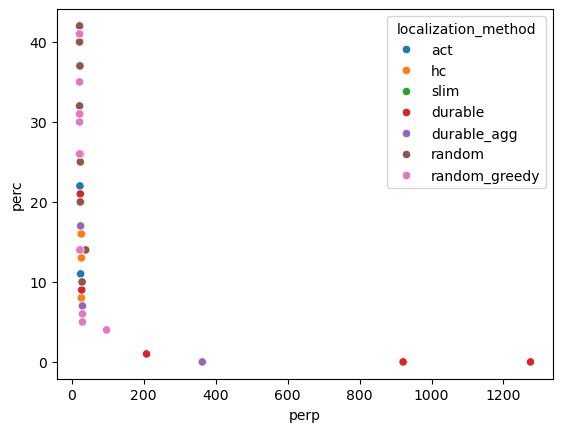

STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped


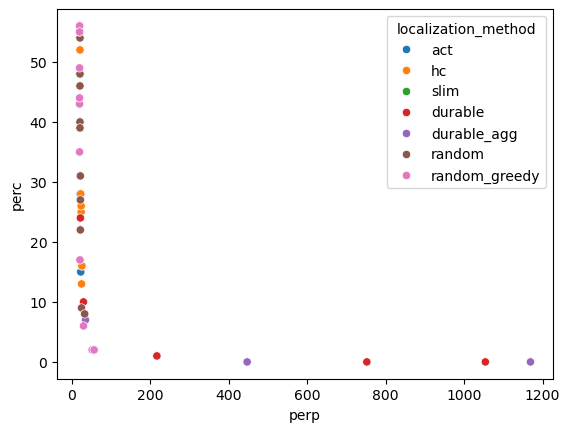

STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped


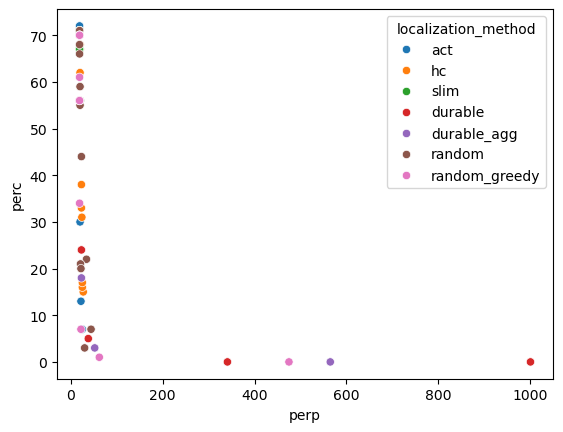

STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped


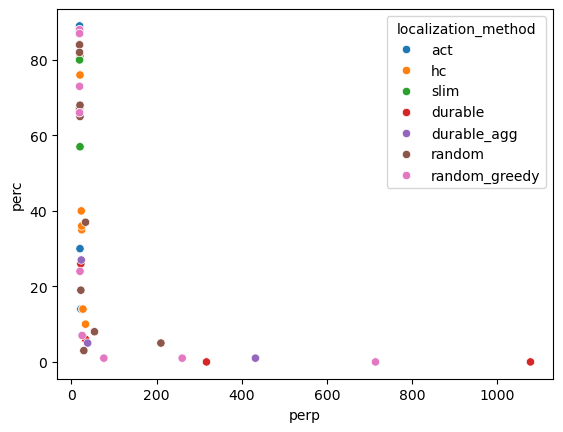

STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped


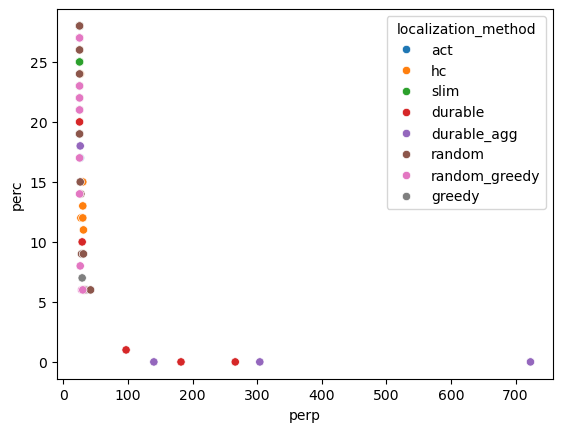

STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped


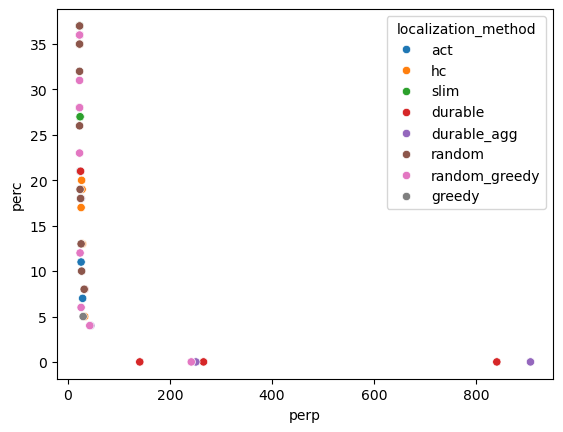

STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped


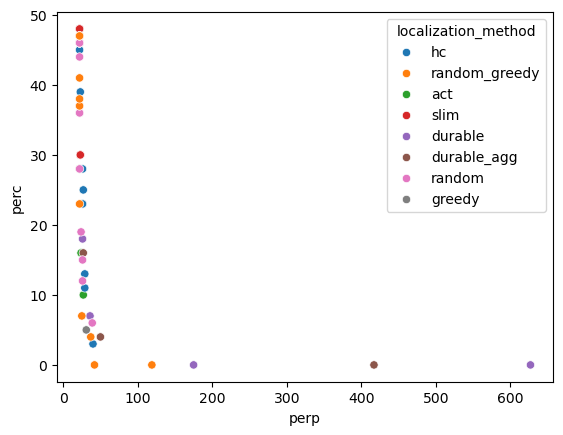

STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped


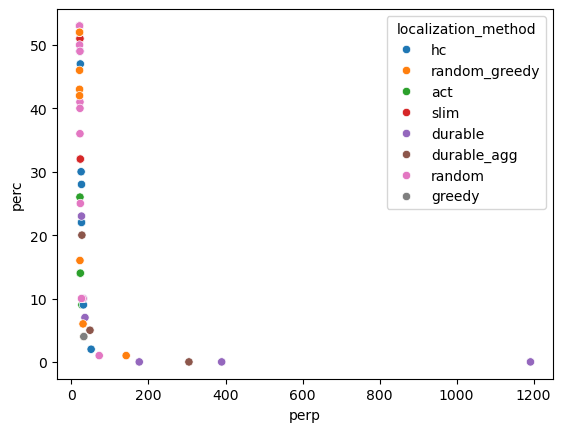

In [327]:


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/{step}/EleutherAI_edit/"
        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method")
        plt.show()

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
0 0
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
1 0
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
2 0
STEP:  143000  model_name:   EleutherAI/pythia-6.9b-deduped
3 0
STEP:  36000  model_name:   EleutherAI/pythia-2.8b-deduped
0 1
STEP:  72000  model_name:   EleutherAI/pythia-2.8b-deduped
1 1
STEP:  108000  model_name:   EleutherAI/pythia-2.8b-deduped
2 1
STEP:  143000  model_name:   EleutherAI/pythia-2.8b-deduped
3 1


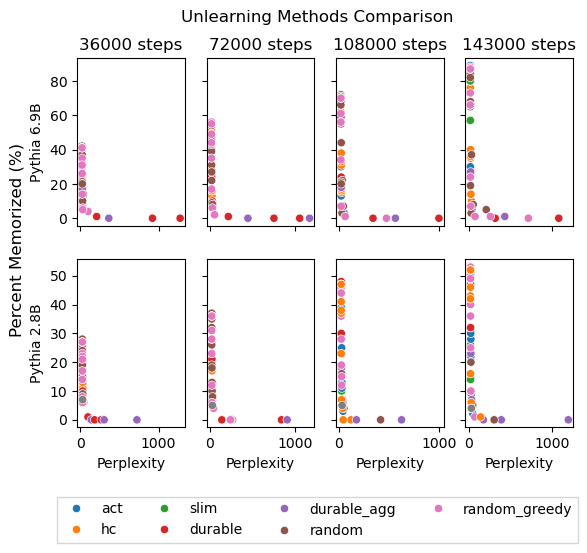

In [328]:
fig, axs = plt.subplots( 2, 4, sharex='col', sharey='row')
fig.suptitle('Unlearning Methods Comparison')
fig.supylabel("Percent Memorized (%)")


y_idx = 0
x_idx = 0


dfs = []
x_idx = 0
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    y_idx = 0
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        #df = return_ideal_method_for_lang(base_stats, df, backdoor=False)
        #print(df)
        dfs.append(copy.deepcopy(df))
        ax = sns.scatterplot(x="perp",
                y="perc",
                data=df,
                hue="localization_method", ax=axs[x_idx, y_idx])
        ax.set_xlabel("Perplexity")
        ax.set_ylabel("Percent Memorized (%)")
        ax.get_legend().remove()

        print(y_idx, x_idx)
        y_idx += 1
    x_idx += 1

rows = ["Pythia 6.9B", "Pythia 2.8B"]
for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row)

cols = [36000, 72000, 108000, 143000]
for ax, col in zip(axs[0], cols):
    ax.set_title(f'{col} steps')
        #plt.show()

#fig.legend(lines, labels, loc = (0.5, 0), ncol=5)
handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
fig.legend(handles = handles , labels=labels,loc='upper center', 
             bbox_to_anchor=(0.5, -0.02),fancybox=False, shadow=False, ncol=4)
plt.savefig(f"pythia_localization_hp_scatter_plot.pdf", bbox_inches='tight')

In [329]:
dfs = []
for model_name in ['EleutherAI/pythia-6.9b-deduped', 'EleutherAI/pythia-2.8b-deduped']:
    for step in [36000, 72000, 108000, 143000]:
        print("STEP: ", step, " model_name:  ", model_name)
        file_name = f"localization_results_{step}.csv"
        result_path = f"/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/{step}/EleutherAI_edit/"

        df = pd.read_csv(f'{result_path}{file_name}')
        for col in df.columns:
            if col in ["perc"]:
                df[col] = df[col].apply(lambda x: round(x, 2))
                df[col] = df[col].apply(lambda x: int(x*100))
            if col in ["perp"]:
                df[col] = df[col].apply(lambda x: int(x) if x < 10000 else x)
            if col in ['ratio']:
                df[col] = df[col].apply(lambda x: round(x, 6))
        df = df[df['model_name'] == model_name]
        #base_stats = df.loc[0].copy()
        base_stats = df[df['unlearn_set_name'].isna()].iloc[0]
        df = df.drop_duplicates()
        dfs.append(copy.deepcopy(df))

        df = return_ideal_method_for_lang(base_stats, df, perp_cutoff= 50, mem_cutoff=10, backdoor=False)
        print(df)
        #print(df.to_latex(index=False))

STEP:  36000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc  perp localization_method ratio epochs
3     42  22.0          BASE_STATS   0.1      1
51     9  28.0             durable  0.01      1
54     7  30.0         durable_agg  0.01      1
109    5  30.0       random_greedy   5.0      1
31     8  27.0                  hc   5.0      1
9      8  26.0                 act   5.0      1
STEP:  72000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc  perp localization_method ratio epochs
3     56  20.0          BASE_STATS   0.1      1
53     7  35.0         durable_agg  0.01      1
90     9  25.0              random   1.0     20
100    6  30.0       random_greedy   0.1     10
9      9  25.0                 act   5.0      1
STEP:  108000  model_name:   EleutherAI/pythia-6.9b-deduped
    perc  perp localization_method ratio epochs
7     72  19.0          BASE_STATS   0.1      1
52     5  38.0             durable  0.01      1
91     3  30.0              random   1.0     20
104   

/tmp/ipykernel_889691/795791966.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8095238095238095' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_889691/795791966.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.8392857142857143' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_889691/795791966.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.9027777777777778' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weight_early.loc[index, "score"] += (row['perc_diff'])
/tmp/ipykernel_889691/795791966.py

Text(0.5, 1.0, 'Unlearning method comparision accorss models + timepoints')

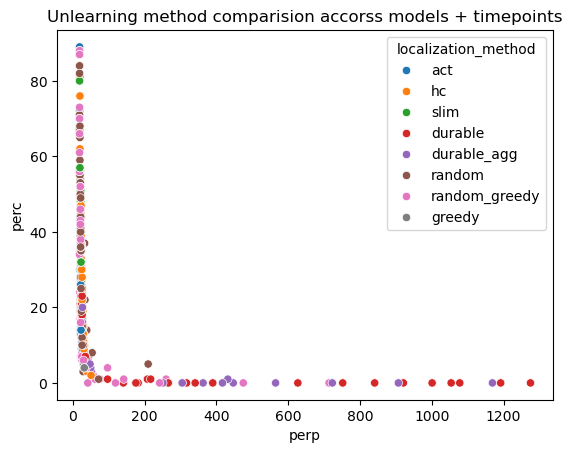

In [330]:
super_df = pd.concat(dfs, axis=0, ignore_index=True)
sns.scatterplot(x="perp",
                y="perc",
                data=super_df,
                hue="localization_method")
plt.title("Unlearning method comparision accorss models + timepoints")

# Unlearn Accross Time

In [340]:
seq_before = []
seq_after = []
ckpt_dir = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/"
steps = [36000, 72000, 108000, 143000]
for step in steps:

    #load original mem set
    mem_seq_original = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
    seq_before.append(mem_seq_original)

    #load mem set after unlearning
    mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/act/mem/0.01/mem_seq_pythia-2.8b-deduped', map_location=torch.device('cpu'))
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/greedy/mem/1e-05/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/random_greedy/mem/0.01/1/0.1/0.9/0.0005/mem_seq_pythia-2.8b-deduped')
    #mem_seq_after_edit = torch.load(f'{ckpt_dir}{step}/EleutherAI_edit/durable/mem/0.01/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
    seq_after.append(mem_seq_after_edit)

In [341]:
for seq in seq_before:
    print(seq.shape)

torch.Size([213, 80])
torch.Size([285, 80])
torch.Size([363, 80])
torch.Size([451, 80])


In [342]:
for seq in seq_after:
    if type(seq) == list:
        seq = torch.Tensor(seq)
    print(seq.shape)

torch.Size([47, 80])
torch.Size([57, 80])
torch.Size([80, 80])
torch.Size([69, 80])


In [343]:
def get_common_mem_seq_at_all_time(seq_before):
    #bc we unlearn at different time points, we want to find a common subset of points that is memorized at each training set
    
    base_mem_seq = seq_before[0] # the earliest timepiont has fewest mem seqence
    common_seqs = []
    for row in base_mem_seq: #iterate thru all rows of base mem seq
        common = False
        for seq in seq_before: #see if later time points contain it
            if row in seq:
                common=True
                
        if common:
            common_seqs.append(copy.deepcopy(row.cpu()))
    
    return torch.stack(common_seqs, dim=0)

In [344]:
common_seqs = get_common_mem_seq_at_all_time(seq_before)

In [345]:
common_seqs.shape #there are 80 common seqences memorized at each time point (we will compare unlearning methods on these 80 sequences

torch.Size([213, 80])

In [346]:
common_seqs.device

device(type='cpu')

In [347]:

for seq in seq_after:
    count = 0
    for row in seq:
        for c in common_seqs:
            if torch.equal(row, c):

                count += 1
            
    print("count: ", count)

count:  36
count:  36
count:  48
count:  44


In [348]:
def check_overlap(seq_after, common_seqs, steps=steps):
    #Now we want to compare unlearning at multiple timepoints!
    not_unlearn_set_over_time = []
    for seq in seq_after:
        #print(seq.shape)
        #print(seq.shape)
        if type(seq) == list:
            seq = torch.Tensor(seq)
        seq = seq.to("cpu")
        not_unlearn_set = []
        count = 0
        #print(seq)
        #print(common_seqs)
        for row in seq:
            for c in common_seqs:
                if torch.equal(row, c):
                    #print("row not unlearned")
                    not_unlearn_set.append(copy.deepcopy(row))
                    count += 1
        #print("count: ", count)
        #print(torch.stack(not_unlearn_set, dim=0).shape)
        if not_unlearn_set != []:
            not_unlearned_set = torch.stack(not_unlearn_set, dim=0)
        else:
            not_unlearned_set = torch.Tensor([])
        not_unlearn_set_over_time.append(copy.deepcopy(not_unlearned_set))
        
    print("Common Mem seqence count: ", common_seqs.shape)
    
    for i in range(len(steps)):
        step = steps[i]
        #print("# of not unlearned seqences: ", not_unlearn_set_over_time[i].shape)
        print(f"Perc unlearn @ step {step}: ", 100 * (common_seqs.shape[0] - not_unlearn_set_over_time[i].shape[0])/ common_seqs.shape[0], "%")
    
    return not_unlearn_set_over_time # we wnat to know how many of these sequenes were unlearned overtime
    

In [349]:
not_unlearn_set_over_time = check_overlap(seq_after, common_seqs)

Common Mem seqence count:  torch.Size([213, 80])
Perc unlearn @ step 36000:  83.09859154929578 %
Perc unlearn @ step 72000:  83.09859154929578 %
Perc unlearn @ step 108000:  77.46478873239437 %
Perc unlearn @ step 143000:  79.34272300469483 %


Interestingly in the above setting, it appears the same unlearning method (act), unlearns worse at later timesteps, rather than earlier timesteps

In [350]:
# interpret results!

In [351]:
not_unlearn_set_over_time[0].shape

torch.Size([36, 80])

# Iterate through all models (timings)

In [354]:
def print_edited_model_paths(parent_path):
    list_of_models = []

    total_exp = 0
    for model_name in ["pythia-6.9b-deduped", "pythia-2.8b-deduped"]:
        y_idx = 0
        for loc_method in [
            "act",
            "hc",
            "slim",
            "durable",
            "durable_agg",
            "random",
            "random_greedy",
            "greedy",
        ]: 
            for ratio in [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.25, 0.3]:
                seq_before = []
                seq_after = []
                steps = [36000, 72000, 108000, 143000]
                for step in steps:
                    result_path = (
                        f"{parent_path}{step}/EleutherAI_edit/{loc_method}/mem/{ratio}"
                    )
                    if loc_method not in ["random", "random_greedy"]:
                        if ratio >= 0.1:
                            continue

                    # this ratio is too small for neuron-level methods
                    if loc_method in ["zero", "hc", "ig", "slim", "act"]:
                        if ratio <= 0.0001:
                            continue

                    if loc_method in ["greedy"]:
                        if ratio > 0.00001:
                            continue

                    ######
                    if loc_method in ["greedy", "durable", "durable_agg", "act"]:
                        model_path = f"{result_path}/{model_name}"
                        mem_seq_path = f"{result_path}/mem_seq_{model_name}"
                        total_exp += 1

                    if loc_method in ["slim", "hc"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = (
                                f"{result_path}/{epochs}/1000/0.1/0.1/{model_name}"
                            )
                            mem_seq_path = model_path = (
                                f"{result_path}/{epochs}/1000/0.1/0.1/mem_seq_{model_name}"
                            )

                    if loc_method in ["random", "random_greedy"]:
                        for epochs in [1, 10, 20]:
                            total_exp += 1
                            model_path = (
                                f"{result_path}/{epochs}/0.1/0.9/0.0005/{model_name}"
                            )
                            mem_seq_path = (
                                f"{result_path}/{epochs}/0.1/0.9/0.0005/mem_seq_{model_name}"
                            )
                    if os.path.isfile(model_path):
                        print("edited model exists:", model_path)
                        print(mem_seq_path)
                        list_of_models.append(model_path)
                        
                        
                        #load original mem set
                        if "2" in model_name:
                            mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-2.8b-deduped',map_location=torch.device('cpu'))
                        if "6" in model_name:
                            mem_seq_original = torch.load(f'{parent_path}{step}/EleutherAI_edit/mem_seq_pythia-6.9b-deduped',map_location=torch.device('cpu'))
                        seq_before.append(mem_seq_original)
                        #print(len(seq_before))
                        
                        #load mem set after unlearning
                        mem_seq_after_edit = torch.load(mem_seq_path,map_location=torch.device('cpu'))
                        seq_after.append(mem_seq_after_edit)
                        
                    else:
                        print("edited model doesn't exist yet: ", model_path)

                if len(seq_before) == len(steps):
                    common_seqs = get_common_mem_seq_at_all_time(seq_before)
                    not_unlearn_set_over_time = check_overlap(seq_after, common_seqs)


    print("total_expeirments: ", total_exp)
    return list_of_models

parent_path = "/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/"

list_of_models = print_edited_model_paths(parent_path)

edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/36000/EleutherAI_edit/act/mem/0.001/mem_seq_pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/72000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/72000/EleutherAI_edit/act/mem/0.001/mem_seq_pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/108000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/108000/EleutherAI_edit/act/mem/0.001/mem_seq_pythia-6.9b-deduped
edited model exists: /pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/act/mem/0.001/pythia-6.9b-deduped
/pscratch/sd/m/mansisak/memorization/model_ckpts/old_run/143000/EleutherAI_edit/act/mem/0.001/mem_

# Git commit

In [24]:
!git add /pscratch/sd/m/mansisak/memorization/figs/pythia_unlearning_results.ipynb
!git commit -m "updated unlearning visualization/analysis"

[WARNING] Unstaged files detected.
[INFO] Stashing unstaged files to /global/u1/m/mansisak/.cache/pre-commit/patch1723956011-2351179.
black................................................(no files to check)Skipped
[INFO] Restored changes from /global/u1/m/mansisak/.cache/pre-commit/patch1723956011-2351179.
[main 3e4c32e] updated unlearning visualization/analysis
 1 file changed, 1 insertion(+), 1 deletion(-)
